In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
plt.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm
pd.options.display.max_columns=100

In [2]:
data = pd.read_csv('Dyadic_COW_4.0.csv')
data = data.iloc[:,2:7]
data.head()

,year,importer1,importer2,flow1,flow2
0,1920,United States of America,Canada,611.85999,735.47998
1,1921,United States of America,Canada,335.44000,442.98999
2,1922,United States of America,Canada,364.01999,502.84000
3,1923,United States of America,Canada,416.00000,598.14001
4,1924,United States of America,Canada,399.14001,496.32001


Now, a first step is to reshape the data so that the flow2 column is below flow 1.

In [3]:
# Data flow1
data_flow_1 = data.loc[:, ['year', 'importer1', 'importer2', 'flow1']]
data_flow_2 = data.loc[:, ['year', 'importer1', 'importer2', 'flow2']]
data_flow_1.columns = ['year', 'Country_A', 'Country_B', 'flow']
data_flow_2.columns = ['year', 'Country_B', 'Country_A', 'flow']
# Dataset in good shape
df = pd.concat([data_flow_1, data_flow_2]).sort_index().reset_index(drop=True)
df.head()

,Country_A,Country_B,flow,year
0,United States of America,Canada,611.85999,1920
1,Canada,United States of America,735.47998,1920
2,United States of America,Canada,335.44000,1921
3,Canada,United States of America,442.98999,1921
4,United States of America,Canada,364.01999,1922


The flow represents the imports of Country_A from Country_B, in US millions of current dollars.

### Descriptive statistics about the evolution of the network

In [5]:
n_nodes = []
n_edges = []
for i in range(1950,2015):
    data_more_1950 = df.loc[np.where(df.year==i)[0], :]
    n_nodes.append(data_more_1950['Country_A'].nunique())
    n_edges.append(len(data_more_1950))

In [6]:
df_resume = pd.DataFrame({'year':[i for i in range(1950,2015)], 'Nb_nodes': n_nodes, 'Nb_edges':n_edges})

Text(0,0.5,'Number of nodes')

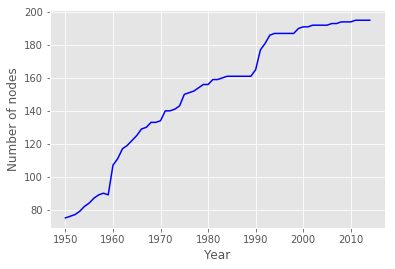

In [7]:
plt.plot(df_resume.year, df_resume.Nb_nodes, c = 'blue')
plt.xlabel('Year')
plt.ylabel('Number of nodes')

The number of country in the network increases.

Text(0,0.5,'Number of edges')

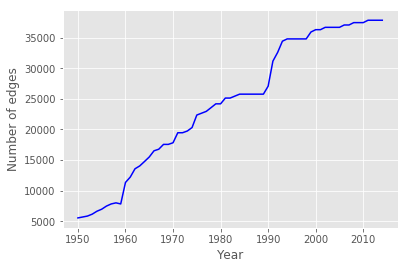

In [8]:
plt.plot(df_resume.year, df_resume.Nb_edges, c = 'blue')
plt.xlabel('Year')
plt.ylabel('Number of edges')

The number of exchanges increases.

Text(0,0.5,'Number of exchanges per country')

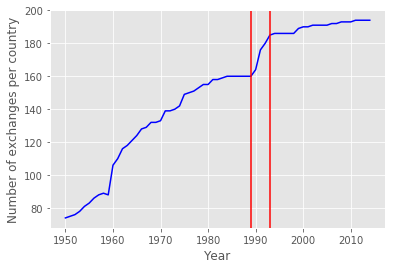

In [9]:
plt.plot(df_resume.year, df_resume.Nb_edges / df_resume.Nb_nodes, c = 'blue')
plt.axvline(x=1989, c = 'red')
plt.axvline(x=1993, c = 'red')
plt.xlabel('Year')
plt.ylabel('Number of exchanges per country')

The number of relation per country increases.

We can notice a drop in the years 1989-1993. It can come from the explosion of URSS. I will verify it.

In [10]:
lost_countries = list(set(df.loc[np.where(df.year==1989)[0],:].Country_A) - 
                      set(df.loc[np.where(df.year==1993)[0],:].Country_A))
new_countries = list(set(df.loc[np.where(df.year==1993)[0],:].Country_A) - 
                      set(df.loc[np.where(df.year==1989)[0],:].Country_A))

In [11]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
# Get coordinated of new countries
coordinates_new_countries = []
for i in new_countries:
    try:
        location = geolocator.geocode(i)
        coordinates_new_countries.append((location.latitude, location.longitude))
    except:
        coordinates_new_countries.append(('lat not found', 'lon not found'))
# Get coordinated of lost countries
coordinates_lost_countries = []
for i in lost_countries:
    try:
        location = geolocator.geocode(i)
        coordinates_lost_countries.append((location.latitude, location.longitude))
    except:
        coordinates_lost_countries.append(('lat not found', 'lon not found'))

In [12]:
df = pd.DataFrame({'Name': new_countries, 'lat': [i[0] for i in coordinates_new_countries], 'long': [i[1] for i in coordinates_new_countries]})

In [13]:
df.head()

,Name,lat,long
0,Armenia,4.492390,-75.739602
1,Andorra,42.540717,1.573203
2,Macedonia,41.617121,21.716839
3,Uzbekistan,41.323730,63.952810
4,Latvia,56.840649,24.753764


In [18]:
data = [ dict(
        type = 'scattergeo',
        lon = df['long'],
        lat = df['lat'],
        text = df['Name'],
        mode = 'markers',
        marker = dict(
            size = 3,
            opacity = 1,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            color='red'
        ))]

layout = dict(
        title = 'New countries between 1989 and 1993',
        colorbar = True,
        geo = dict(
            scope = 'europe',
            projection=dict( type='mollweide' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False)

Aw, snap! We don't have an account for ''. Want to try again? You can authenticate with your email address or username. Sign in is not case sensitive.

Don't have an account? plot.ly

Questions? accounts@plot.ly


PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, '', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.

## World map - inter-continent trade flows

### dynamic centroids

In [90]:
#trade data from 1950
df_map = data[data.year>=1950]
#take off missing values
df_map = df_map[df_map.flow1>0]
df_map = df_map[df_map.flow2>0]
#sum import and export
df_map['flow'] = df_map.flow1 + df_map.flow2
df_map.drop(['flow1','flow2'],axis=1,inplace=True)
df_map=df_map.rename(columns={'importer1':'Country'})


In [91]:
#trade data from 1950
df_map = data[data.year>=1950]
#take off missing values
df_map = df_map[df_map.flow1>0]
df_map = df_map[df_map.flow2>0]
#sum import and export
df_map['flow'] = df_map.flow1 + df_map.flow2
df_map.drop(['flow1','flow2'],axis=1,inplace=True)
df_map=df_map.rename(columns={'importer1':'Country'})

#grouping by continent
continent = eval(open("continent.py").read())

continent_dict = {}
for i, j in enumerate(continent):
    continent_dict.update({continent[i]['name']: continent[i]['continent']})
    
countries = list(df_map.Country.unique())

continent_dict.update({'United States of America': 'North America', 'St. Lucia':'North America','St. Vincent and the Grenadines':'North America',
 'Antigua & Barbuda':'North America', 'St. Kitts and Nevis':'North America', 'Ireland':'Europe', 'Netherlands':'Europe',
 'German Federal Republic':'Europe', 'German Democratic Republic':'Europe', 'Czechoslovakia':'Europe',
 'Yugoslavia':'Europe', 'Kosovo':'Europe', 'Sao Tome and Principe':'Africa','Gambia':'Africa', 'Ivory Coast':'Africa',
 'Congo':'Africa','Zanzibar':'Africa','South Sudan':'Africa', 'Yemen Arab Republic':'Asia',
 'Yemen People\'s Republic':'Asia', 'China':'Asia', 'Taiwan':'Asia', 'Republic of Vietnam':'Asia', 'Brunei':'Asia'})

df_map['Continent_A'] = list(map(continent_dict.get, df_map.importer2))

df_map['Continent_B'] = list(map(continent_dict.get, df_map.Country))


#df_cont = df_cont.iloc[:,:2]
#df_map = pd.merge(df_map,df_cont,on='Country')
#df_cont=df_cont.rename(columns={'Country':'importer2'})
#df_map = pd.merge(df_map,df_cont,on='importer2')
#df_map=df_map.drop(['Country','importer2'],axis=1)
##now we have flows at the continent level. We ignore internal flows and aggreate inter-continent flows
df_map = df_map[df_map['Continent_A']!=df_map['Continent_B']]
df_map['Continent_link']=df_map[['Continent_A' , 'Continent_B']].values.tolist()
df_map['Continent_link']=df_map['Continent_link'].sort_values().apply(lambda x: sorted(x))
df_map['Continent_link']=df_map['Continent_link'].str.join(',')
df_map.head()

,year,Country,importer2,flow,Continent_A,Continent_B,Continent_link
1825,1950,United States of America,Colombia,590.39999,South America,North America,"North America,South America"
1826,1951,United States of America,Colombia,660.29999,South America,North America,"North America,South America"
1827,1952,United States of America,Colombia,694.79999,South America,North America,"North America,South America"
1828,1953,United States of America,Colombia,840.10001,South America,North America,"North America,South America"
1829,1954,United States of America,Colombia,964.89999,South America,North America,"North America,South America"


In [92]:
df_mapct=df_map[['flow','Continent_link','year']].groupby(['Continent_link','year']).sum()
df_mapct['Continent']=df_mapct.index
df_mapct.index = np.arange(0,len(df_mapct))
df_mapct['year']=df_mapct['Continent'].apply(lambda x:x[1])
df_mapct['Continent']=df_mapct['Continent'].apply(lambda x:x[0])
df_mapct['Continent']=df_mapct['Continent'].str.split(",")
df_mapct['Continent_A']=df_mapct['Continent'].apply(lambda x:x[0])
df_mapct['Continent_B']=df_mapct['Continent'].apply(lambda x:x[1])
df_mapct.drop('Continent',axis=1,inplace=True)
df_mapct.head()

,flow,year,Continent_A,Continent_B
0,196.700003,1950,Africa,Asia
1,221.400000,1951,Africa,Asia
2,243.999998,1952,Africa,Asia
3,266.839995,1953,Africa,Asia
4,295.540000,1954,Africa,Asia


In [93]:
#aggregate of trade flows per continent per year
df_sum_cont = pd.concat([df_mapct.groupby(['Continent_A','year']).sum(),df_mapct.groupby(['Continent_B','year']).sum()])
df_sum_cont['Continent']=np.array(df_sum_cont.index.get_level_values(0))
df_sum_cont['year']=np.array(df_sum_cont.index.get_level_values(1))
df_sum_cont.index=np.arange(0,len(df_sum_cont))
df_sum_cont['year']=df_sum_cont['year'].apply(int)
df_sum_cont=df_sum_cont.sort_values(by=['year'],axis=0)
df_sum_cont = df_sum_cont.groupby(['year','Continent']).sum()
df_sum_cont['Continent']=np.array(df_sum_cont.index.get_level_values(1))
df_sum_cont['year']=np.array(df_sum_cont.index.get_level_values(0))
df_sum_cont.index=np.arange(0,len(df_sum_cont))
df_sum_cont.head(10)

,flow,Continent,year
0,2106.320001,Africa,1950
1,6116.230014,Asia,1950
2,15281.219960,Europe,1950
3,12917.869955,North America,1950
4,3629.189970,Oceania,1950
5,6389.129987,South America,1950
6,2647.889995,Africa,1951
7,8381.630019,Asia,1951
8,21250.980055,Europe,1951
9,18191.449980,North America,1951


In [94]:
#coordinates of continents
#ORDER: Africa, Asia, Europe, North America, Oceania, South America
long=[5,130,5,-100,150,-60]
lat=[20,40,50,40,-30,-15]

In [95]:
#calculate the global centroid from averages of long/lat weighted by trade flows of each continent
weights_cont = np.array(df_sum_cont)
weighted_avg_lat = []
weighted_avg_long = []
centroid = []

for i in np.arange(0,len(weights_cont)-6,6):
    #weighted_avg_lat.append( np.dot(lat,weights_cont[i:(i+6),0])/np.sum(weights_cont[i:(i+6),0]) )
    #weighted_avg_long.append( np.dot(long,weights_cont[i:(i+6),0])/np.sum(weights_cont[i:(i+6),0]) )
    centroid.append( [np.dot(long,weights_cont[i:(i+6),0])/np.sum(weights_cont[i:(i+6),0]),
                     np.dot(lat,weights_cont[i:(i+6),0])/np.sum(weights_cont[i:(i+6),0])] )
#weighted_avg_lat = np.dot(lat,weights_cont)/np.sum(weights_cont)
#weighted_avg_long = np.dot(long,weights_cont)/np.sum(weights_cont)
#centroid = [weighted_avg_long[0],weighted_avg_lat[0]]
#print("Global centroid coordinates are",centroid)

In [96]:
df_mapct2012 = df_mapct[df_mapct.year==2012]

In [97]:
#first we need to build up the network G
import networkx as nx
G=nx.Graph()

df_mapct = df_mapct[df_mapct.year==2012]


continent = df_sum_cont['Continent'].unique()

#nodes = country in upper case
for ct in continent:
    G.add_node(ct)


#edges = export+import flow
for i in range(len(df_mapct)):
            weighted_edge = (df_mapct.iloc[i,2],df_mapct.iloc[i,3],df_mapct.iloc[i,0])
            G.add_weighted_edges_from([weighted_edge])


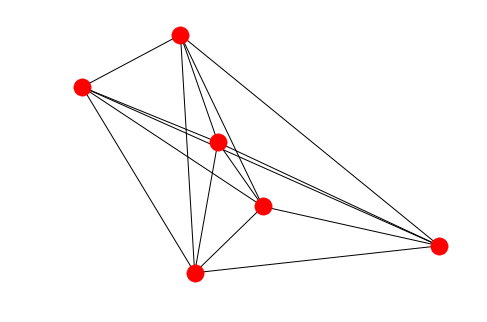

In [98]:
nx.draw(G)
plt.show()

In [99]:
#coordinates of continents
#ORDER: Africa, Asia, Europe, North America, Oceania, South America
long=[5,130,5,-100,150,-60]
lat=[20,40,50,40,-30,-15]

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning:

The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning:

The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning:

The ishold function was deprecated in version 2.0.

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning:

axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:521: UserWarning:

You have mixed posit

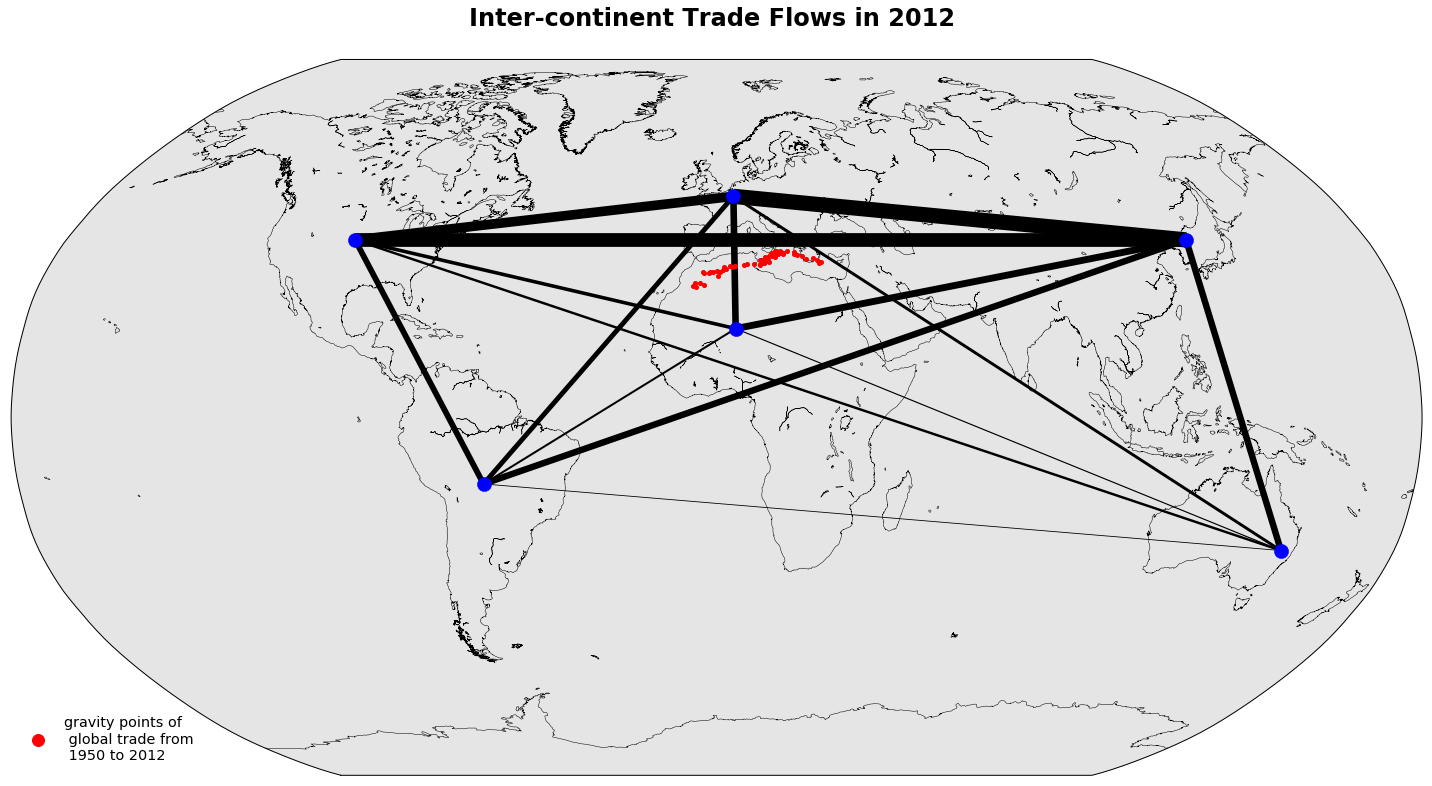

In [100]:
from mpl_toolkits.basemap import Basemap
fig = plt.figure(figsize=(20,20))
m=Basemap(projection='robin',lon_0=0,lat_0=0,resolution='l')
#m = Basemap(
#       projection='robin',
#        lat_ts=0,
#        resolution='l')

m.fillcontinents(lake_color='white',color='white',zorder=0)
m.drawcoastlines(linewidth=0.5)

mx,my=m(long,lat)

# define position in basemap
pos = {}
for i in range(0,len(continent)):
    pos[continent[i]]=(mx[i],my[i])

weights = [G[u][v]['weight'] for u,v in G.edges()]

nx.draw_networkx(G,pos,node_size=200,node_color='blue',width=np.sqrt(weights)*0.01,with_labels=False)

#add the centroids
for cent in centroid:
    m_centroid_x , m_centroid_y = m(cent[0],cent[1])
    centroid_plot = m.plot(m_centroid_x,m_centroid_y,'bo',markersize=4,color='red')

#centroid_map=[]
#for cent in centroid:
#    centroid_map.append(m(cent[0],cent[1]))

#centroid_map_x = np.array(centroid_map)[:,0]
#centroid_map_y = np.array(centroid_map)[:,1]
#centroid_plot = m.plot(centroid_map_x,centroid_map_y,color='red')
    
    
plt.legend(centroid_plot,labels=['gravity points of \n global trade from \n 1950 to 2012'],facecolor='white',fontsize='x-large',\
          markerscale=3,frameon=False)

plt.title("Inter-continent Trade Flows in 2012 \n",fontweight='bold',size=24)
plt.tight_layout()
plt.show()